In [3]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [4]:
file_path = 'violence_dataset'

In [5]:
name_class = os.listdir(file_path)
name_class

['non_violence', 'violence']

In [6]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [7]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [8]:

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,violence_dataset\violence\V_753.mp4_frame1.jpg,violence
1,violence_dataset\violence\V_324.mp4_frame1.jpg,violence
2,violence_dataset\non_violence\NV_995.mp4_frame...,non_violence
3,violence_dataset\violence\V_540.mp4_frame3.jpg,violence
4,violence_dataset\violence\V_820.mp4_frame2.jpg,violence


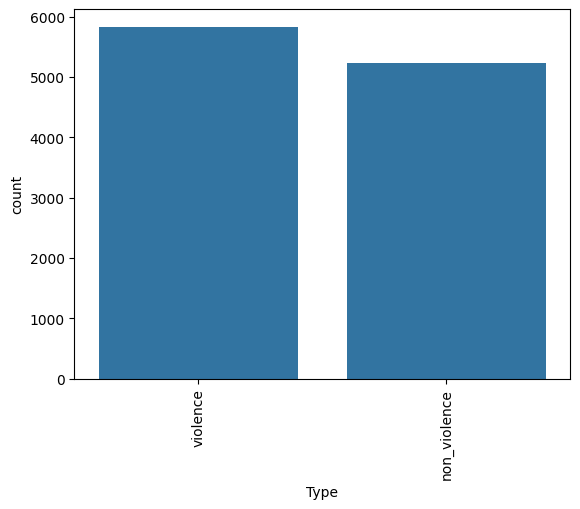

In [9]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [10]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

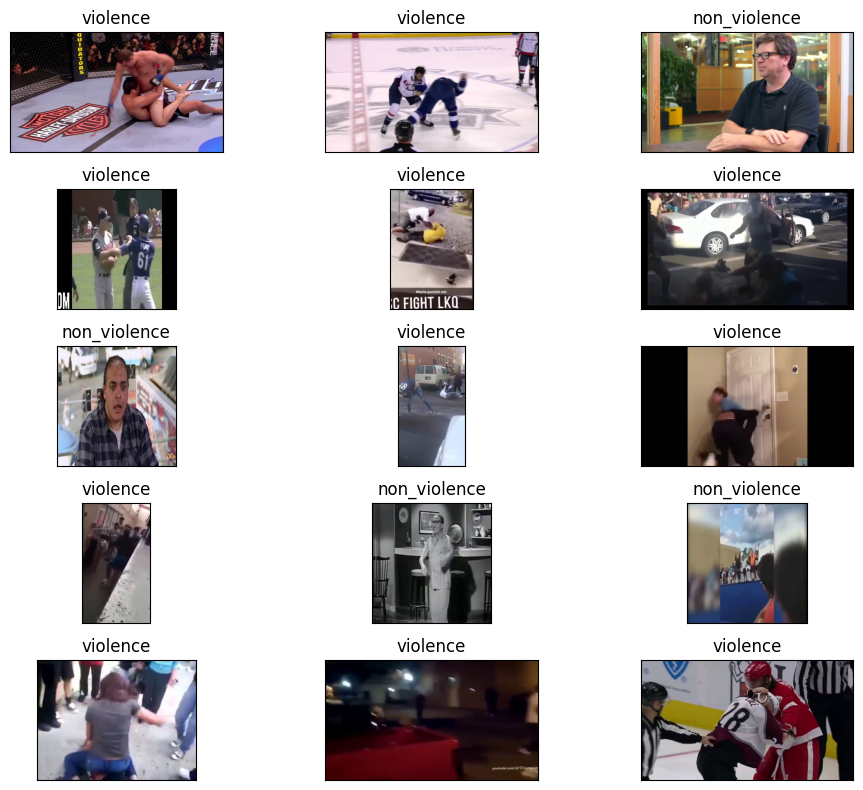

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 8297 validated image filenames belonging to 2 classes.
Found 2766 validated image filenames belonging to 2 classes.
Found 2766 validated image filenames belonging to 2 classes.


In [14]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 15s 0us/step


In [15]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [18]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10
)

Epoch 1/10
260/260 [==============================] - 271s 1s/step - loss: 0.2606 - accuracy: 0.8907 - val_loss: 0.2106 - val_accuracy: 0.9176
Epoch 2/10
260/260 [==============================] - 286s 1s/step - loss: 0.1171 - accuracy: 0.9541 - val_loss: 0.1793 - val_accuracy: 0.9295
Epoch 3/10
260/260 [==============================] - 317s 1s/step - loss: 0.0730 - accuracy: 0.9732 - val_loss: 0.1453 - val_accuracy: 0.9519
Epoch 4/10
260/260 [==============================] - 339s 1s/step - loss: 0.0449 - accuracy: 0.9852 - val_loss: 0.2055 - val_accuracy: 0.9382
Epoch 5/10
260/260 [==============================] - 367s 1s/step - loss: 0.0380 - accuracy: 0.9863 - val_loss: 0.1683 - val_accuracy: 0.9497
Epoch 6/10
260/260 [==============================] - 222s 855ms/step - loss: 0.0298 - accuracy: 0.9904 - val_loss: 0.1877 - val_accuracy: 0.9497
Epoch 7/10
260/260 [==============================] - 225s 865ms/step - loss: 0.0307 - accuracy: 0.9882 - val_loss: 0.2166 - val_accuracy: 

In [19]:
model.save("model_resnet50.h5")  

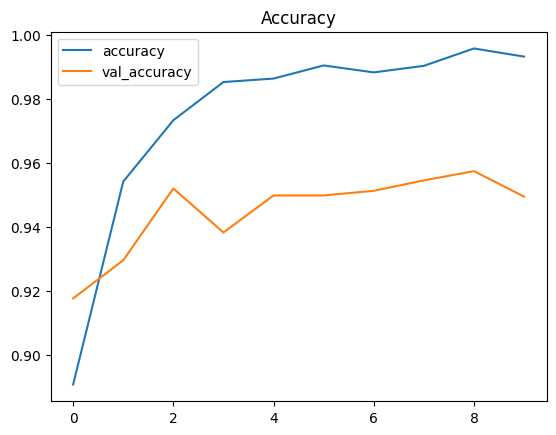

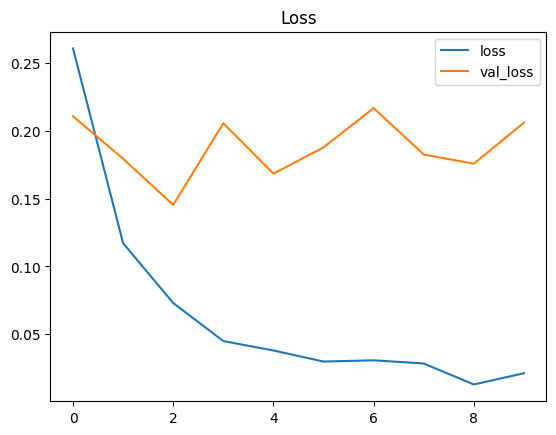

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [21]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.20591
Test Accuracy: 94.94%


In [22]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

87/87 [==============================] - 63s 712ms/step


In [23]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

non_violence       0.96      0.93      0.94      1254
    violence       0.94      0.97      0.95      1512

    accuracy                           0.95      2766
   macro avg       0.95      0.95      0.95      2766
weighted avg       0.95      0.95      0.95      2766



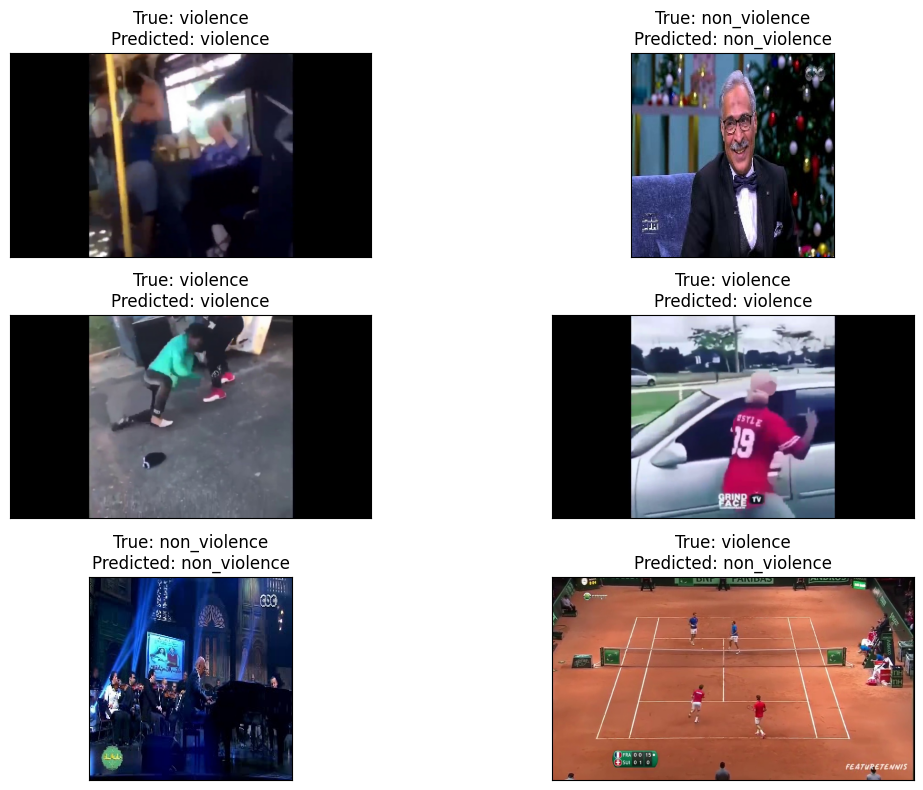

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()